# Biophysical and reduced neuronal models

## Generic code architecture for model construction

In [1]:
#Modl params

#Run controls

#DAQ vector instantiation

#Initialization

#Helper fxns (eqns)

#Integrator

#Package DAQ vector(s) into intuitive data structure

#I.O

## Hodgkin-Huxley neuron model

### Charge conservation equation

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + I_{0}$$

### Current equations (where i $\in$ {Na, K, pas} and j, k, z $\geq$ 0)

$$I_{i} = \bar{g}_{i}m^{j}h^{k}n^{z}(V - E_{i})$$

### Gating dynamic equations (where p $\in$ {m, h, b})

$$\frac{dp}{dt} = \alpha_{p}(V_m)(1 - p) - \beta_{p}(V_{m})p$$

### Rate constant equations

#### m

$$\alpha_{m} = \frac{0.01(25 - V_{m})}{e^{\frac{25 - V_{m}}{10}} - 1}$$

$$\beta_{m} = 4e^{-\frac{V_{m}}{18}}$$

#### h

$$\alpha_{h} = 0.07e^{-\frac{V_{m}}{20}}$$

$$\beta_{h} = \frac{1}{e^{\frac{30 - V_{m}}{10}} - 1}$$

#### n

$$\alpha_{n} = \frac{0.01(10 - V_{m})}{e^{\frac{10 - V_{m}}{10}} - 1}$$

$$\beta_{n} = 0.125e^{-\frac{V_{m}}{80}}$$

#### $\infty$ (steady-state) equations (where p $\in$ {m, h, n})

$$p_{\infty} = \frac{\alpha_{p}}{\alpha_{p} + \beta_{p}} $$


In [2]:
###Sys block
from warnings import simplefilter
simplefilter(action = 'ignore')
from random import seed
seed(120622)

###Lib block
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sbn
from random import gauss, uniform
from sklearn.metrics import mean_squared_error as mse
from IPython.display import HTML, Image
import ray as rClust
from tqdm import tqdm

In [3]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
i_, c_m = 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiations
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, i_, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + i_) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              i_, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-3.220631
1,960.025,-3.167730
2,960.050,-3.114805
3,960.075,-3.061856
4,960.100,-3.008888


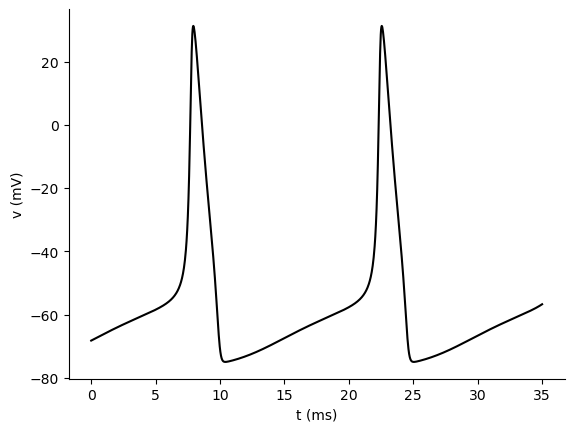

In [4]:
#Visualization
plt.figure()
plt.plot(data['t'] - min(data['t']), 
         data['v'] - 65,
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hodgkin-Huxley model compared to biological spiker

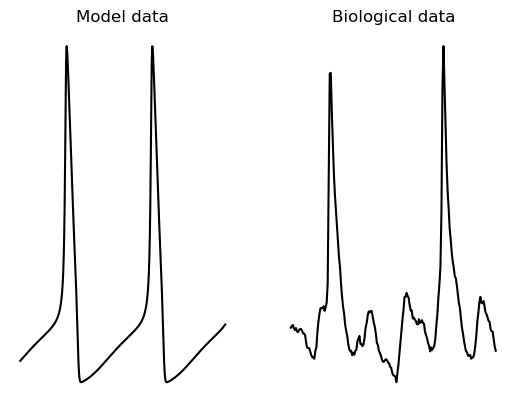

In [5]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hodgkin-Huxley model with noise compared to biological spiker

### Charge conservation equation with additive noise

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + w\xi + I_{0}$$


In [6]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
w, i_, c_m = 25, 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiations
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              w, i_, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-8.686479
1,960.025,-7.601745
2,960.050,-7.555722
3,960.075,-7.411587
4,960.100,-8.228261


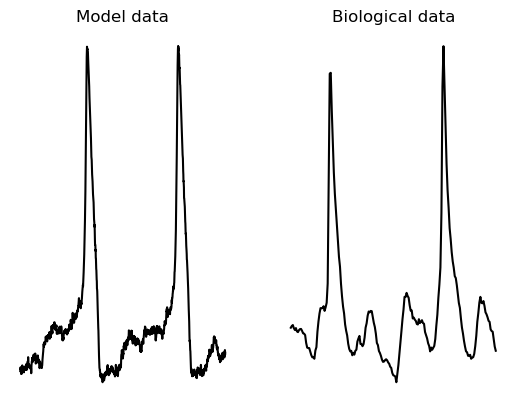

In [7]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose neuron model

### System of differential equations

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + i$$

$$\frac{dy}{dt} = c - dx^{2} - y$$

$$\frac{dz}{dt} = r(s(x - x_{1}) - z)$$

In [8]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * (x ** 3) + b * (x ** 2) - z + i_
    dydt = c - d * (x ** 2) - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.532801
1,1000.01,-1.532784
2,1000.02,-1.532768
3,1000.03,-1.532751
4,1000.04,-1.532735


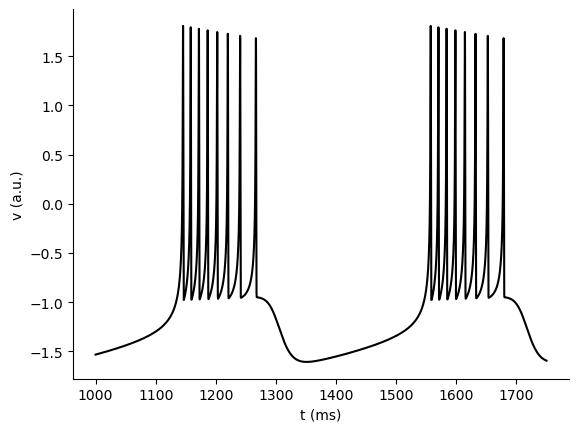

In [9]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['x'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (a.u.)')
plt.show()

## Hindmarsh-Rose model compared to biological burster

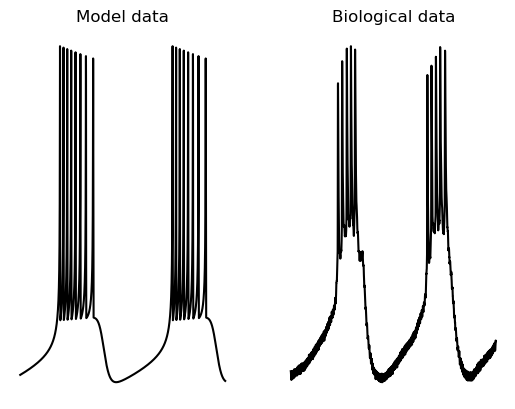

In [10]:
#Data dump
biolData = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose model with noise compared to biological burster

### Voltage-representing, state-variable equation with additive noise

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + w\xi + i$$

In [11]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2
w = 1

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
    dydt = c - d * x ** 2 - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.472408
1,1000.01,-1.482756
2,1000.02,-1.483776
3,1000.03,-1.480185
4,1000.04,-1.478846


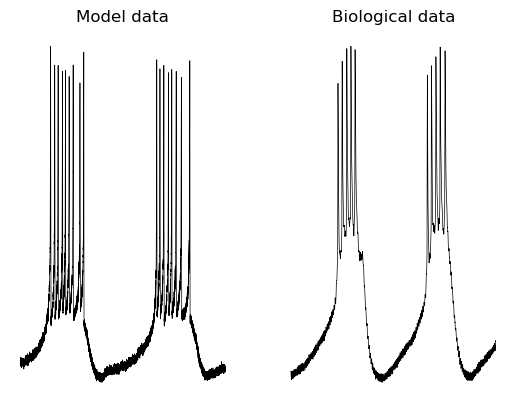

In [12]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         linewidth = 0.5,
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Draw visualization to jupyter
plt.show()

## Izhikevich neuron model

### System of differential equations

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + i$$

$$\frac{du}{dt} = a(bv - u)$$

<br><br>

<p style = "text-align: center;">if $v = 30 \: mV$, then:</p> 

$$v \leftarrow c$$
$$u \leftarrow u + d$$

## ...as spiker

In [13]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
i_ = 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-70.935316
1,900.01,-70.932249
2,900.02,-70.929181
3,900.03,-70.926114
4,900.04,-70.923046


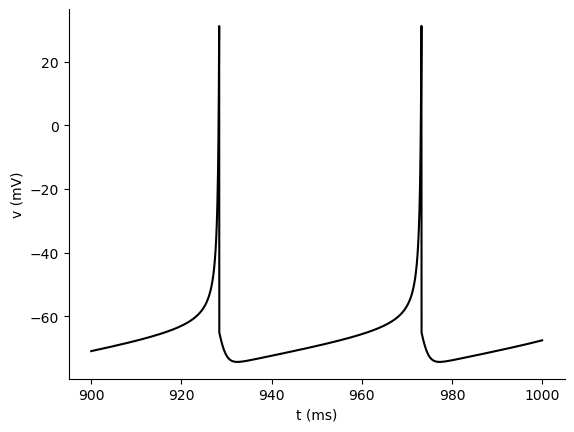

In [14]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## ...as burster

In [15]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
i_ = 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-69.019385
1,900.01,-69.014446
2,900.02,-69.009506
3,900.03,-69.004563
4,900.04,-68.999619


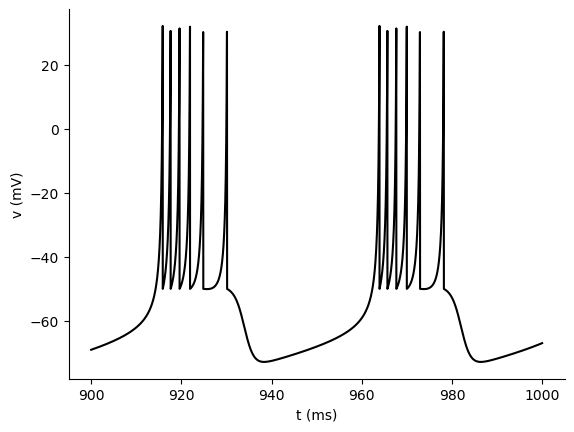

In [16]:
#Visualization
plt.figure()
plt.plot(data_['t'], 
         data_['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Izhikevich model compared to biological neurons

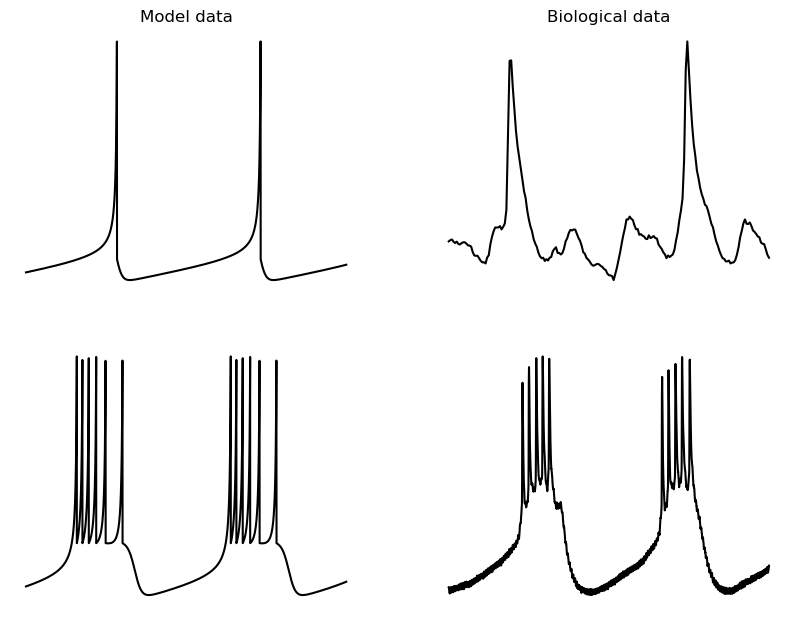

In [17]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')
biolData_ = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure(figsize = (10, 7.5))

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

## Izhikevich model with noise compared to biological neurons

### Voltage-representing, state-variable equation with additive noise

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + w\xi + i$$

## ...as spiker

In [18]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
w, i_ = 10, 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-69.244225
1,900.01,-69.222449
2,900.02,-69.261061
3,900.03,-69.312373
4,900.04,-69.442575


## ...as burster

In [19]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
w, i_ = 10, 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                      'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-62.993644
1,900.01,-62.786875
2,900.02,-62.499059
3,900.03,-62.436780
4,900.04,-62.565752


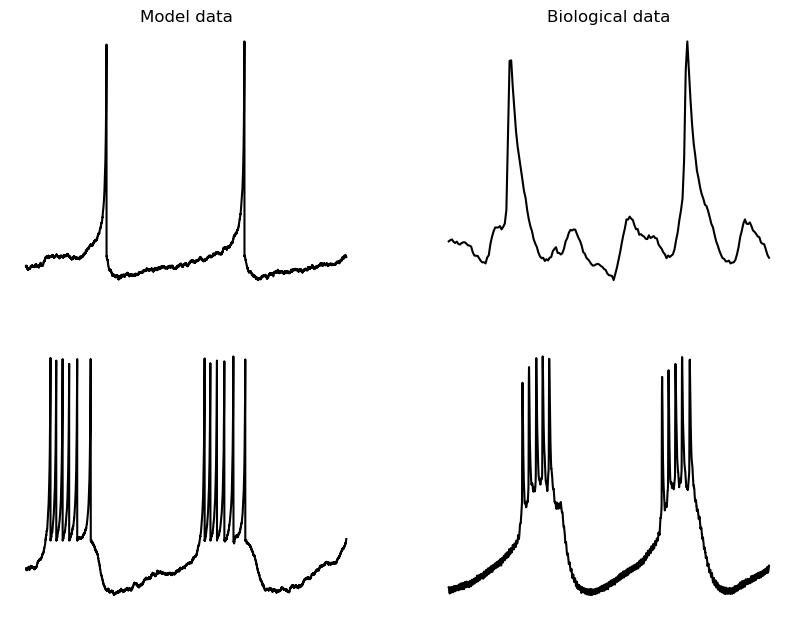

In [20]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (10, 7.5))

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

# Parameter search and optimization methodologies

## Toy univariate linear regression model

$$y = mx + b$$

In [21]:
###Main block
#Modl params
m, b = 100, 10

#IV/feature/predictor/EV vector
x = np.arange(1, (10 + 1))

#Helper fxn (eqn)
def fx():
    return(m * x + b)

#Compute modl output
y = fx()
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'x': x,
                     'y': y})

#I.O
data.head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


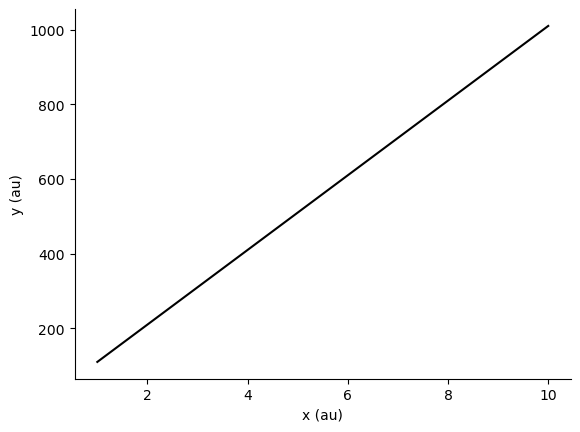

In [22]:
#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.show()

## Parameter search (hand-tuning; brute-force; random parameter)

### Functionalize toy model

In [23]:
###Fxn block
def toyModl(m, b = 10):
    '''
    
    Fxnalized univariate linear regression modl object
    
    - Modl params are now fxn args
        * m is parg/kwarg
        * b is darg
    
    '''
    
    #IV/feature/predictor/EV vector
    x = np.arange(1, (10 + 1))
    
    #Helper fxn (eqn)
    def fx():
        return(m * x + b)
    
    #Compute modl output
    y = fx()
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'x': x,
                         'y': y})
    
    #I.O
    return(data)

###Main block
#Compute modl results
toyModl(m = 100).head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


### Hand-tune toy model

$$m \in [0, 100]$$

m = 50


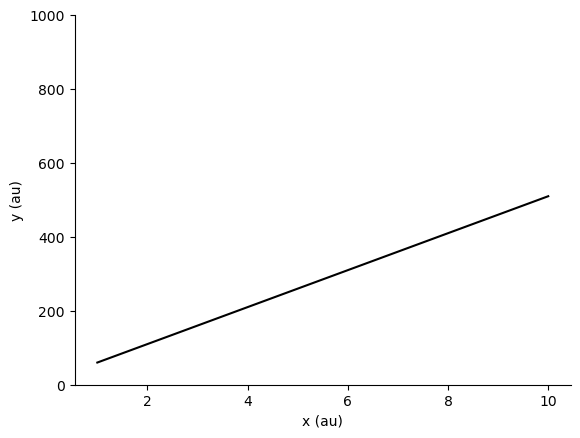

In [24]:
###Main block
#Compute modl results
data = toyModl(m = int(input('m =')))

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Subject toy model to brute-force, sparse-grid search

In [25]:
###Main block
##Create param iterable
#Sparse 1D grid comprising feature space
m = np.arange(0, 100, 10)

#DAQ list-column instantiation
modls = []

#Compute modl outputs across grid
for i,_ in enumerate(m):
    #Conditionally capture x and y for first iteration
    if i == 0:
        modls.append(toyModl(m = m[i]))

    #Conditionally capture y for remainder of iterations
    else:
        modls.append(toyModl(m = m[i])['y'] \
             .rename(f'y{i}'))
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,10,20,30,40,50,60,70,80,90,100
1,2,10,30,50,70,90,110,130,150,170,190
2,3,10,40,70,100,130,160,190,220,250,280
3,4,10,50,90,130,170,210,250,290,330,370
4,5,10,60,110,160,210,260,310,360,410,460


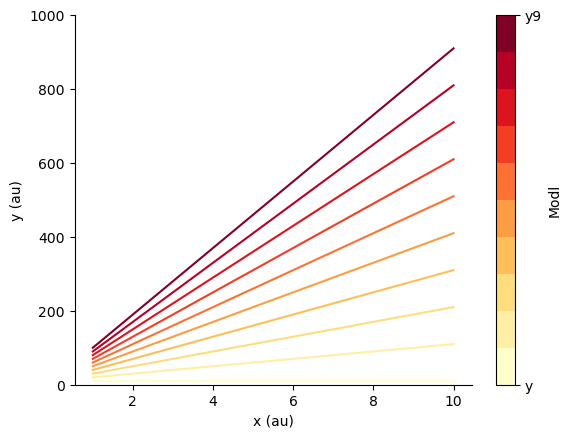

In [26]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
clrs = cmap(range(len(data.iloc[:, 1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Render visualization to jupyter
plt.show()

### Subject toy model to random parameter search

In [27]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (m) selection
while i <= n:
    #Conditionally capture x and y for first iteration
    if i == 0:
        modls.append(toyModl(m = uniform(0, 100 + 1)))

    #Conditionally capture y for remainder of iterations
    else:
        modls.append(toyModl(m = uniform(0, 100 + 1))['y'] \
             .rename(f'y{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,62.558415,62.259131,39.798298,85.777635,106.686368,16.722492,18.762590,21.779533,89.596867,95.836452
1,2,115.116830,114.518263,69.596596,161.555270,203.372737,23.444984,27.525181,33.559065,169.193733,181.672905
2,3,167.675245,166.777394,99.394894,237.332906,300.059105,30.167475,36.287771,45.338598,248.790600,267.509357
3,4,220.233660,219.036526,129.193192,313.110541,396.745474,36.889967,45.050361,57.118131,328.387467,353.345809
4,5,272.792075,271.295657,158.991490,388.888176,493.431842,43.612459,53.812951,68.897664,407.984334,439.182262


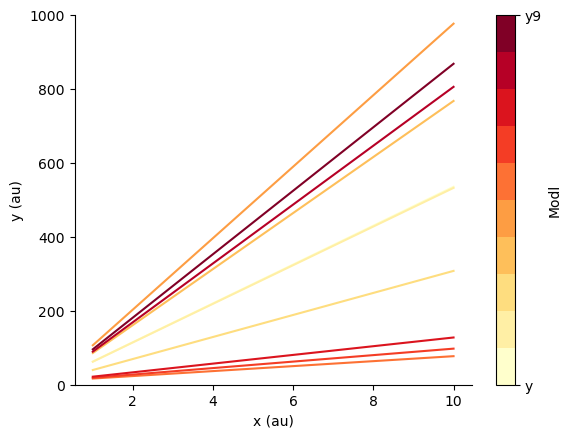

In [28]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
clrs = cmap(range(len(data.iloc[:, 1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Render visualization to jupyter
plt.show()

## Optimization methodologies (random parameter search; gradient descent)

### Optimization (i.e., target) data

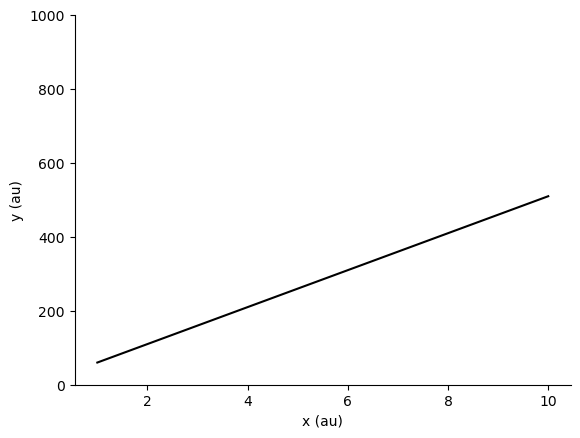

In [29]:
###Main block
##Compute modl results
#Use complex (i.e., multi-) object assignment
data = optoData \
     = toyModl(m = 50)

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Optimize toy model to target data using random parameter search

In [30]:
###Fxn block
def sideBySide(*dfs):
    '''

    Jupyter render fxn, placing variable number of dfs side-by-side
    
    '''
    
    ##Construct div object with column-wise 'display:flex' div style
    html = '<div style = "display:flex">'
    
    #Iteratively concat dfs column-wise
    for df in dfs:
        #Appending df html to root div object
        html += '<div style = "margin-right: 2em">' \
             +  df.to_html() \
             +  '</div>'

    #Close root div
    html += '</div>'

    #Render root div to jupyter
    display(HTML(html))

###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ tensor instantiations
modls = []
error = []

#Compute modl outputs subject to Monte-Carlo param (m) selection
while i <= n:
    if i == 0:
        #Conditionally capture x and y for first iteration
        modls.append(toyModl(m = uniform(0, 100 + 1)))

        #Capture MSE error signal between target data and modl output for first iteration
        error.append(mse(optoData['y'], modls[i]['y']))

    else:
        #Conditionally capture y for remainder of iterations
        modls.append(toyModl(m = uniform(0, 100 + 1))['y'] \
             .rename(f'y{i}'))

        #Capture MSE error signal between target data and modl output for remainder of iterations
        error.append(mse(optoData['y'], modls[i]))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)
data_ = pd.DataFrame({'modl': data.columns.values[1:],
                      'err': error})

#I.O
sideBySide(data.head(), data_.head())

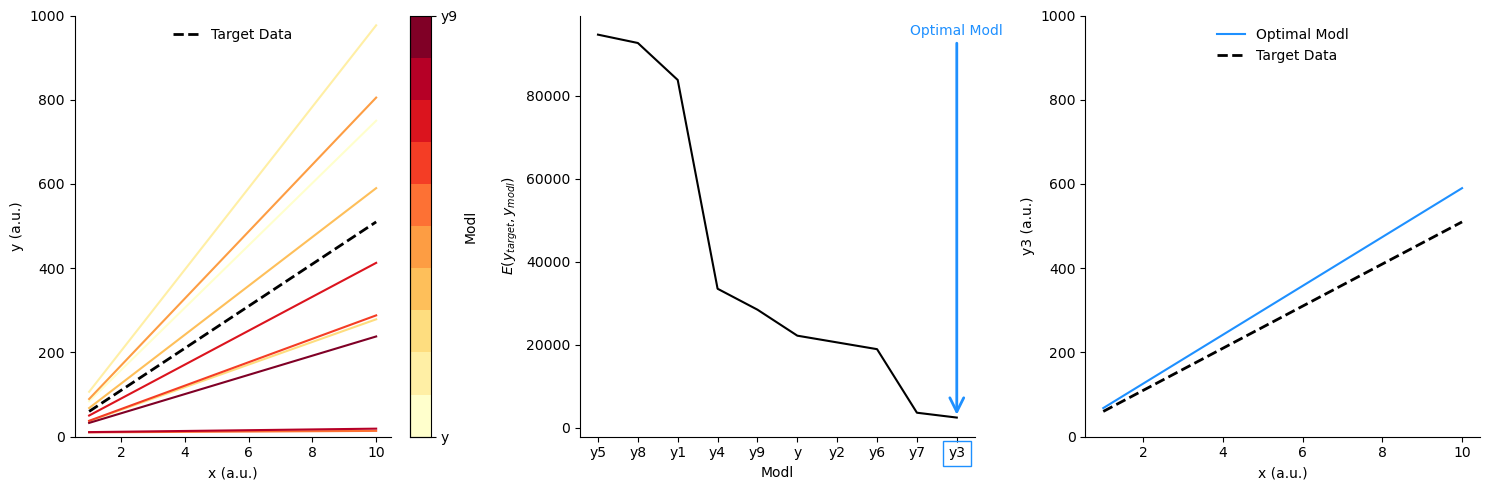

In [31]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 5))

#Instantiate first panel (modl data)
plt.subplot(131)

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.columns[1:]))
clrs = cmap(range(len(data.columns[1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 131 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

##Build legend
#Standard legend with mappable 'label'
plt.legend(frameon = False,
           loc = 'upper center')

#Color-encoded legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Instantiate second panel (biological data)
plt.subplot(132)

#Wrangle for visualization
temp = data_.sort_values(by = 'err', ascending = False) \
            .reset_index()

#Construct figure
plt.plot(temp['modl'], 
         temp['err'],
         color = 'black')

#Identify min in error landscape (i.e., optimal modl)
plt.annotate(text = 'Optimal Modl', 
             xy = (temp[(temp['err'] == min(temp['err']))]['modl'].index[0], 
                   temp['err'].min()), 
             xytext = (temp[(temp['err'] == min(temp['err']))]['modl'].index[0], 
                       temp['err'].max()),
             horizontalalignment = 'center',
             arrowprops = dict(arrowstyle = '->, ' \
                                          + 'head_width = 0.5, ' \
                                          + 'head_length = 1',
                               linewidth = 2,
                               color = 'dodgerblue'),
             color = 'dodgerblue')

#Highlight optimal model
plt.gca() \
   .xaxis \
   .get_ticklabels()[temp[(temp['err'] == min(temp['err']))]['modl'] \
   .index[0]] \
   .set_bbox(dict(facecolor = 'none', 
                  edgecolor = 'dodgerblue'))

#Alter subplot 132 attributes
sbn.despine()
plt.xlabel('Modl')
plt.ylabel('$E(y_{target}, y_{modl})$')

#Instantiate third panel (optimized modl data)
plt.subplot(133)

#Construct figure
plt.plot(data['x'], 
         data[data_[(data_['err'] == min(data_['err']))]['modl']],
         color = 'dodgerblue',
         label = 'Optimal Modl')

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 133 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel(f'y{data_[(data_["err"] == min(data_["err"]))]["modl"].index[0]} (a.u.)')
plt.ylim(0, 1000)

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Alter graphics device layout
plt.tight_layout()

#Render visualization to jupyter
plt.show()

### Optimize toy model to target data using gradient descent

#### Recapitulate toy model as simple neural network (i.e., a simple perceptron)

<p style = 'text-align:center;'><img src = './fts/simplePerceptron.jpg' alt = 'SimplePerceptron' width = '500' height = '1000'></p>

$$y = mx + b$$

<br><br>

<p style = 'text-align: center;'>where:</p> 

$$m \in [0, 100]$$

$$b = 10$$

#### Gradient descent algorithm

##### Master equation

$$m_{i + 1} = m_{i} - \mu\frac{\partial \xi}{\partial m}$$

##### Error/fitness/loss function for batch learning

$$\xi = \frac{1}{N} \sum_{1}^{N}{{\left\lvert Y_{target} - Y_{modl} \right\rvert}^{2}}$$

##### Solve $\frac{\partial \xi}{\partial m}$ using the chain rule

$$\frac{\partial \xi}{\partial m} = \frac{\partial \xi}{\partial Y_{modl}} \frac{\partial Y_{modl}}{\partial m}$$

<br><br>

$$\frac{\partial \xi}{\partial Y_{modl}} = \frac{\partial}{\partial Y_{modl}}(\frac{1}{N} \sum_{1}^{N}{{\left\lvert Y_{target} - Y_{modl} \right\rvert}^{2}})$$

$$ = \frac{1}{N} \sum_{1}^{N} {\frac{\partial}{\partial Y_{modl}}({Y_{target} - Y_{modl}})^{2}}$$

$$ = \frac{1}{N} \sum_{1}^{N}{2({Y_{modl} - Y_{target}})}$$

<br><br>

$$\frac{\partial Y_{modl}}{\partial m} = \frac{\partial}{\partial m}(mX + b)$$

$$ = X$$

<br><br>

$$\frac{\partial \xi}{\partial m} = \frac{\partial \xi}{\partial Y_{modl}} \frac{\partial Y_{modl}}{\partial m} = \frac{1}{N} \sum_{1}^{N}{2X({Y_{modl} - Y_{target}})}$$

#### Closed-form master equation

$$m_{i + 1} = m_{i} - \frac{\mu}{N} \sum_{1}^{N}{2X({Y_{modl} - Y_{target}})}$$

In [32]:
###Fxn block
def errorLandscape():
    ##Create param iterable
    #Sparse 1D grid comprising feature space
    m = np.arange(0 + 10, 100 - 9)
    
    #DAQ list-column instantiation
    errors = []
    
    #Compute modl outputs across grid
    for i,_ in enumerate(m):
        #Capture MSE error signal between target data and modl output
        errors.append(mse(optoData['y'], toyModl(m = m[i])['y']))
        
    #Transform to nd heterogenous df
    data = pd.DataFrame({'m': m, 
                         'err': errors})
    
    #I.O
    return(data)

###Main block
#Modl params
m = 15
u = 0.01

#Compute controls
i = 0
n = 10 - 1

##DAQ tensor instantiations
#Use complex (i.e., multi-) object assignment
modls = modl \
      = [toyModl(m)]
errors = [[m, mse(optoData['y'], toyModl(m)['y'])]]

#Helper fxns (eqns)
def weightedGradient(X, Y_modl, Y_target):
    return(u * np.mean(2 * X * (Y_modl - Y_target)))

#Implementation of gradient descent
while i <= n:
    if i == 0:
        #Compute gradient with learning rate
        dEdm = weightedGradient(modl[0]['x'], modl[0]['y'], optoData['y'])

    else:
        #Compute gradient with learning rate
        dEdm = weightedGradient(modl['x'], modl['y'], optoData['y'])

    #Update param
    m = m - dEdm

    #Compute modl output with updated param
    modl = toyModl(m)

    ##Capture data
    #Acquire modl data
    modls.append(modl['y'] \
         .rename(f'y{i}'))

    #Acquire optimization param and error data
    errors.append([m, mse(optoData['y'], modl['y'])])
    
    #Increase iterator
    i += 1

#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)
data_ = pd.DataFrame(errors, columns = ['m', 'err'])
data_.insert(loc = 0, 
             column = 'modl',
             value = data.columns.values[1:])


#I.O
sideBySide(data.head(), data_.head())

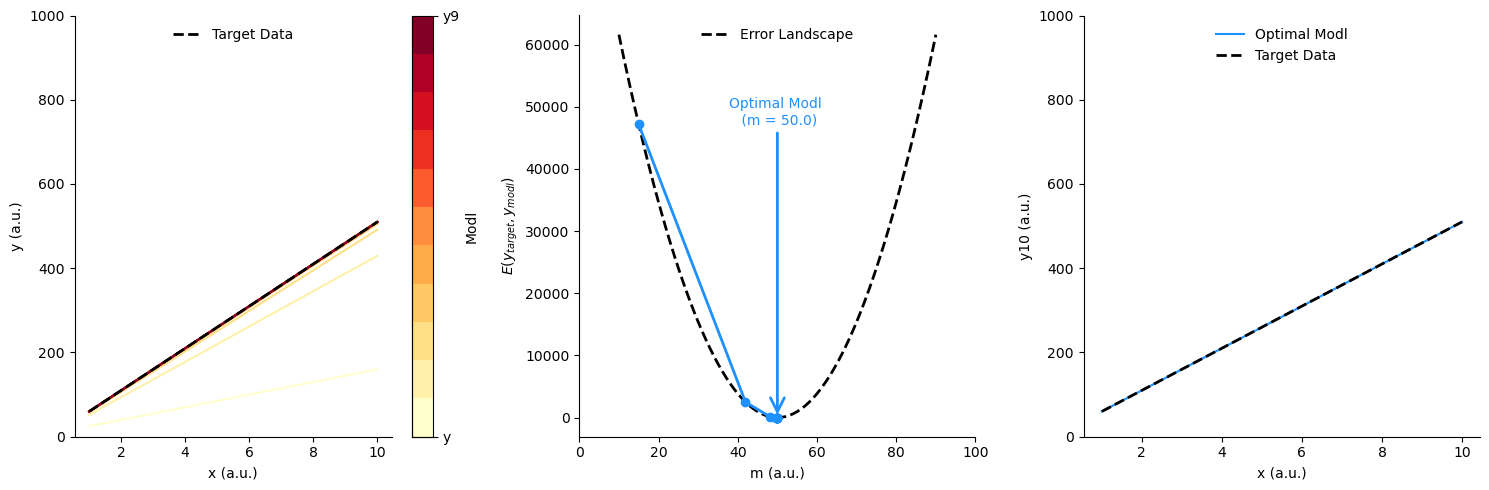

In [33]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 5))

#Instantiate first panel (modl data)
plt.subplot(131)

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.columns[1:]))
clrs = cmap(range(len(data.columns[1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 131 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

##Build legend
#Standard legend with mappable 'label'
plt.legend(frameon = False,
           loc = 'upper center')

#Color-encoded legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Instantiate second panel (biological data)
plt.subplot(132)

#Generate error landscape data
dataError = errorLandscape()

#Initialize figure with error well
plt.plot(dataError['m'],
         dataError['err'],
         color = 'black',
         linestyle = 'dashed',
         linewidth = 2,
         label = 'Error Landscape')

#Visualize descent of error signal down gradient
plt.plot(data_['m'], 
         data_['err'],
         color = 'dodgerblue',
         marker = 'o',
         linestyle = 'solid',
         linewidth = 2)

#Identify min in error landscape (i.e., optimal modl)
plt.annotate(text = f'Optimal Modl \n (m = {round(data_[data_["err"] == min(data_["err"])]["m"].values[0], 2)})', 
             xy = (data_[(data_['err'] == min(data_['err']))]['m'], 
                   data_['err'].min()), 
             xytext = (data_[(data_['err'] == min(data_['err']))]['m'], 
                       data_['err'].max()),
             horizontalalignment = 'center',
             arrowprops = dict(arrowstyle = '->, ' \
                                          + 'head_width = 0.5, ' \
                                          + 'head_length = 1',
                               linewidth = 2,
                               color = 'dodgerblue'),
             color = 'dodgerblue')

#Alter subplot 132 attributes
sbn.despine()
plt.xlabel('m (a.u.)')
plt.xlim(0, 100)
plt.ylabel('$E(y_{target}, y_{modl})$')

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Instantiate third panel (optimized modl data)
plt.subplot(133)

#Construct figure
plt.plot(data['x'], 
         data[data_[(data_['err'] == min(data_['err']))]['modl']],
         color = 'dodgerblue',
         label = 'Optimal Modl')

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         color = 'black',
         linestyle = 'dashed',
         linewidth = 2,
         label = 'Target Data')

#Alter subplot 133 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel(f'y{data_[(data_["err"] == min(data_["err"]))]["modl"].index[0]} (a.u.)')
plt.ylim(0, 1000)

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Alter graphics device layout
plt.tight_layout()

#Render visualization to jupyter
plt.show()

### Functionalize Hodgkin-Huxley model

In [34]:
###Fxn block
def hhModl(i_):
    '''
    
    Fxnalized classical Hodgkin-Huxley modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
    e_na, e_k, e_pas = 115, -12, 10.6
    w, c_m = 25, 1
    
    #Run controls
    time, dt = 1000, 0.025
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ vector instantiations
    v, m, h, n = [], [], [], []
    
    #Helper fxns (eqns)
    def alpha_m(v):
        return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))
    
    def beta_m(v):
        return(4 * np.exp(-v / 18))
    
    def alpha_h(v):
        return(0.07 * np.exp(-v / 20))
    
    def beta_h(v):
        return(1 / (np.exp ((30 - v) / 10) + 1))
    
    def alpha_n(v):
        return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))
    
    def beta_n(v):
        return(0.125 * np.exp(-v / 80))
    
    def dmdt(v, m):
        return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))
    
    def dhdt(v, h):
        return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))
    
    def dndt(v, n):
        return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))
    
    def i_na(gbar_na, m, h, v, e_na):
        return((gbar_na * (m ** 3) * h * (v - e_na)))
    
    def i_k(gbar_k, n, v, e_k):
        return((gbar_k * (n ** 4)) * (v - e_k))
    
    def i_pas(gbar_pas, v, e_pas):
        return(gbar_pas * (v - e_pas))
        
    def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_, c_m):
        return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_) / c_m)
    
    ###Initialization
    ##Initialize voltage
    v.append(0)
    
    ##Initialize state vars
    #Fxns iterable
    fxns = [[alpha_m, beta_m],
            [alpha_h, beta_h],
            [alpha_n, beta_n]]
    
    #State-vars iterable
    sVars = [m, h, n]
    
    #Iteratively initialize state vars
    for i,_ in enumerate(fxns):
        sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                                  gbar_na, gbar_k, gbar_pas, 
                                  e_na, e_k, e_pas,
                                  w, i_, c_m))
        m.append(m[i] + dt * dmdt(v[i], m[i]))
        h.append(h[i] + dt * dhdt(v[i], h[i]))
        n.append(n[i] + dt * dndt(v[i], n[i]))
    
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'v': v}) \
             .query('t >= 960 & t <= 995') \
             .reset_index(drop = True)
    
    #I.O
    return(data)

###Main block
#Compute modl results
hhModl(i_ = 10).head()

,t,v
0,960.000,-8.556616
1,960.025,-8.432894
2,960.050,-8.748249
3,960.075,-9.213974
4,960.100,-9.290370


### Subject Hodgkin-Huxley model to random parameter search

$$i \in [0, 100]$$

In [35]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (i_) selection
while i <= n:
    #Conditionally capture t and v for first iteration
    if i == 0:
        modls.append(hhModl(i_ = uniform(0, 100 + 1)))

    #Conditionally capture v for remainder of iterations
    else:
        modls.append(hhModl(i_ = uniform(0, 100 + 1))['v'] \
             .rename(f'v{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,960.000,3.398007,15.166042,-3.813839,-11.368999,-9.867816,-0.298987,71.433022,98.833898,6.721577,5.632848
1,960.025,2.710635,14.697688,-3.106799,-12.050959,-9.508482,-0.686761,72.606903,99.689466,6.349875,5.607677
2,960.050,3.518643,14.174628,-4.002903,-10.970846,-8.888394,-1.384419,73.045648,98.662212,6.099573,4.940865
3,960.075,3.734408,14.513088,-4.177899,-12.255509,-9.080285,-0.390338,72.430681,97.377023,6.807666,5.107219
4,960.100,4.083358,14.073013,-4.739512,-12.332896,-9.622707,0.718132,71.169463,97.929074,6.899700,5.229953


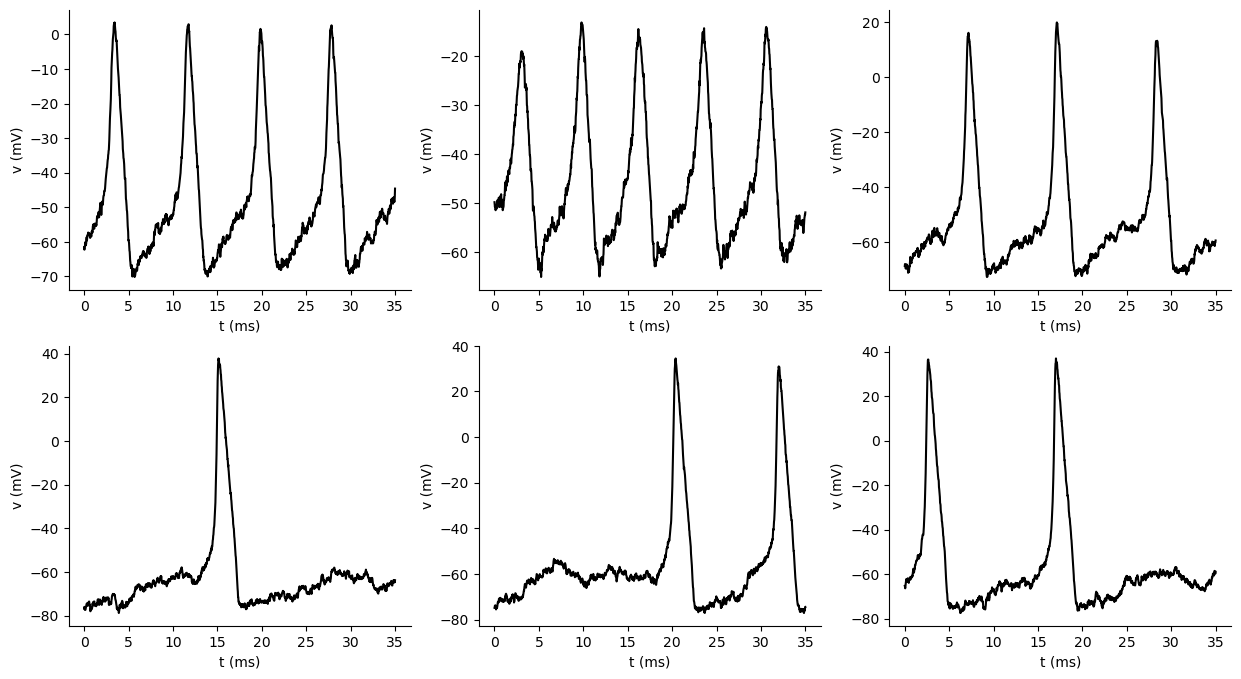

In [36]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'] - min(data['t']),
             data.iloc[:, i + 1] - 65,
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()

### Functionalize Hindmarsh-Rose model

In [37]:
###Fxn block
def hrModl(i_):
    '''
    
    Fxnalized Hindmarsh-Rose modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    a, b, c, d = 1, 3, 1, 5
    r, s, x0, w = 0.001, 4, -1.6, 1
    
    #Run controls
    time, dt = 2000, 0.01
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ tensor instantiation
    sVars = np.zeros((int(n), 3))
    
    #Initialization
    sVars[0] = np.array([0.5, 0.5, 0.5])
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
        x, y, z = sVars
    
        #Compute RHS of ODEs
        dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
        dydt = c - d * x ** 2 - y
        dzdt = r * (s * (x - x0) - z)
    
        #Fxn I.O
        return(np.array([dxdt, dydt, dzdt]))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'x': sVars[:, 0]}) \
             .query('t >= 1000 & t <= 1750') \
             .reset_index(drop = True) 
    
    #I.O
    return(data)

###Main block
#Compute modl results
hrModl(i_ = 2).head()

,t,x
0,1000.00,-1.369325
1,1000.01,-1.369114
2,1000.02,-1.372216
3,1000.03,-1.381302
4,1000.04,-1.374774


### Subject Hindmarsh-Rose model to random parameter search

$$i \in [1.5, 3]$$

In [38]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (i_) selection
while i <= n:
    #Conditionally capture t and x for first iteration
    if i == 0:
        modls.append(hrModl(i_ = uniform(1.5, 3 + 1)))

    #Conditionally capture x for remainder of iterations
    else:
        modls.append(hrModl(i_ = uniform(1.5, 3 + 1))['x'] \
             .rename(f'x{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,t,x,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1000.00,-0.625505,-1.406760,-0.706623,-1.036151,0.270543,-1.378528,-0.699847,-0.614030,-1.494658,-0.979033
1,1000.01,-0.620250,-1.395562,-0.708857,-1.031606,0.261908,-1.365019,-0.698249,-0.615050,-1.485430,-0.970980
2,1000.02,-0.621145,-1.402694,-0.708143,-1.033252,0.266660,-1.382625,-0.708369,-0.615257,-1.479515,-0.974240
3,1000.03,-0.625611,-1.403542,-0.700213,-1.036128,0.271766,-1.382523,-0.711627,-0.627192,-1.484117,-0.991283
4,1000.04,-0.627292,-1.408587,-0.688396,-1.036596,0.275026,-1.391237,-0.706330,-0.640973,-1.469133,-0.990750


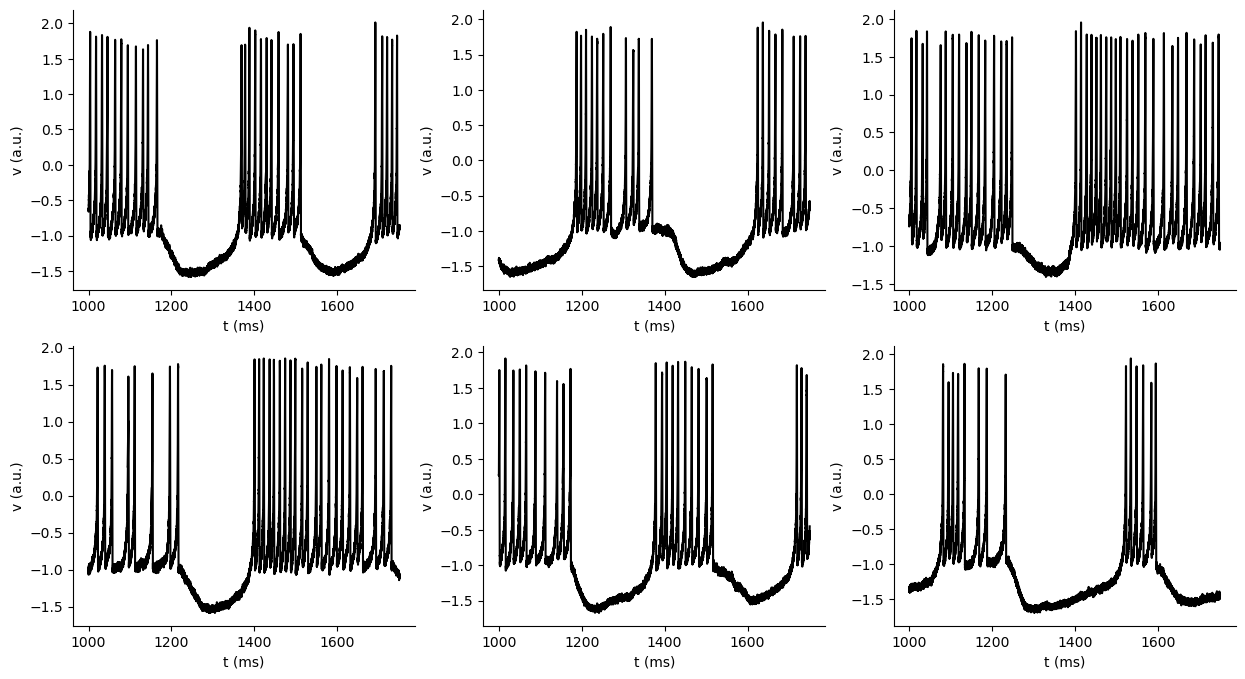

In [39]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'],
             data.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (a.u.)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()